### Stolen from here
https://medium.com/raposa-technologies/4-simple-rsi-trading-strategies-db7b9790c690

The Relative Strength Index (RSI) has long been one of the most popular indicators due to its versatility. It is most commonly used as an oscillator to find reversals in prices, but can also be used as a trend or momentum indicator.

There are hundreds of ways to use this indicator in a trading strategy. Below, we’ll walk through four approaches with backtests, stats, and the code to produce it all.

As always, don’t just dive in and start trading because you saw a pretty backtest, but do your own research. These examples are here to get you started and get you thinking about how you can apply these techniques to your own systems. If you need a review of the RSI, the logic behind it, and how it’s calculated, you can find that here (https://medium.com/raposa-technologies/how-to-use-rsi-in-your-trading-system-7a894e0257d6).

Now, let’s import our Python packages.

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Calculating the RSI
Rsi formula:
$RSI_{t}=100-(\frac{100}{1+RS_{t}})$, where
$RS_{t}$ is the relative strength factor at time $t$
to discover more look at the article linked above

In [1]:
def calcRSI(data, P=14):
  data['diff_close'] = data['Close'] - data['Close'].shift(1)
  data['gain'] = np.where(data['diff_close']>0, 
    data['diff_close'], 0)
  data['loss'] = np.where(data['diff_close']<0,
    np.abs(data['diff_close']), 0)
  data[['init_avg_gain', 'init_avg_loss']] = data[
    ['gain', 'loss']].rolling(P).mean()
  avg_gain = np.zeros(len(data))
  avg_loss = np.zeros(len(data))
  
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < P - 1:
      last_row = row.copy()
      continue
    elif i == P-1:
      avg_gain[i] += row['init_avg_gain']
      avg_loss[i] += row['init_avg_loss']
    else:
      avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
      avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P
    last_row = row.copy()
  data['avg_gain'] = avg_gain
  data['avg_loss'] = avg_loss
  data['RS'] = data['avg_gain'] / data['avg_loss']
  data['RSI'] = 100 - 100 / (1 + data['RS'])
  return data

The `calcRSI` code will be used to calculate RSI for a given data series

# RSI for Overbought and Oversold Positions

The classic use case for the RSI is to find points where the price is at an extreme high or an extreme low. You buy low and short high so that you can ride the security back to the centerline (RSI=50) and exit with a tidy profit.

Frequently, you’ll see this strategy rely on a 14-period RSI with overbought levels of 70 or 80 and oversold levels of 30 or 20. We’ll use this set up with levels at 30 and 70 for going long and short respectively. Feel free to experiment with your own set up, there’s nothing here that’s set in stone or the way it “should” be done — if you can find a profitable strategy with different parameters that tests well, has good stats, and you’re comfortable with, then go for it.



In [6]:
# Standard Mean Reversion
# p is the period in days, long and short level is fairly explanatory
def RSIReversionStrategy(data, P=14, long_level=30, short_level=70,
  centerline=50, shorts=True):
  '''
  Goes long when RSI < long level, sells when the value crosses the
  centerline.
  Goes short when RSI > short level, covers when it crosses the
  centerline.
  '''
  df = calcRSI(data, P=P)
  df['position'] = np.nan
  df['position'] = np.where(df['RSI']<long_level, 1, df['position'])
  if shorts:
    df['position'] = np.where(df['RSI']>short_level, -1,
      df['position'])
  if centerline is not None:
    # Exit when RSI crosses sell_level
    _sell_level = df['RSI'] - centerline
    df['cross_sell_level'] = _sell_level.shift(1) / _sell_level
    df['position'] = np.where(df['cross_sell_level']<0, 0,   
      df['position'])
  else:
    df['position'] = np.where(df['RSI']>=short_level, 0,  
      df['position'])
  
  df['position'] = df['position'].ffill().fillna(0)
  
  return calcReturns(df)
def calcReturns(df):
  # Helper function to avoid repeating too much code
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * \
    df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(
    df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df

The `RSIReversionStrategy` sets up a straightforward mean reversion strategy that is indicative of the classic RSI trading set up. It goes long when the RSI is low, shorts when it's high, and exits the position when it crosses the centerline. All of these values are free for you to play with, but let's turn to running it on some actual data to see how it performs.

We’ll use the `yfinance` package to grab some free data from Yahoo! Finance and use this data across our various models.

In [71]:
ticker = 'bhp'
start = '2010-01-01'
end = '2020-12-31'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start=start, end=end)
# Drop unused columns to keep things simple
data.drop(['Open', 'High', 'Low', 'Volume', 'Dividends',
  'Stock Splits'], inplace=True, axis=1)

Running test and plotting the results

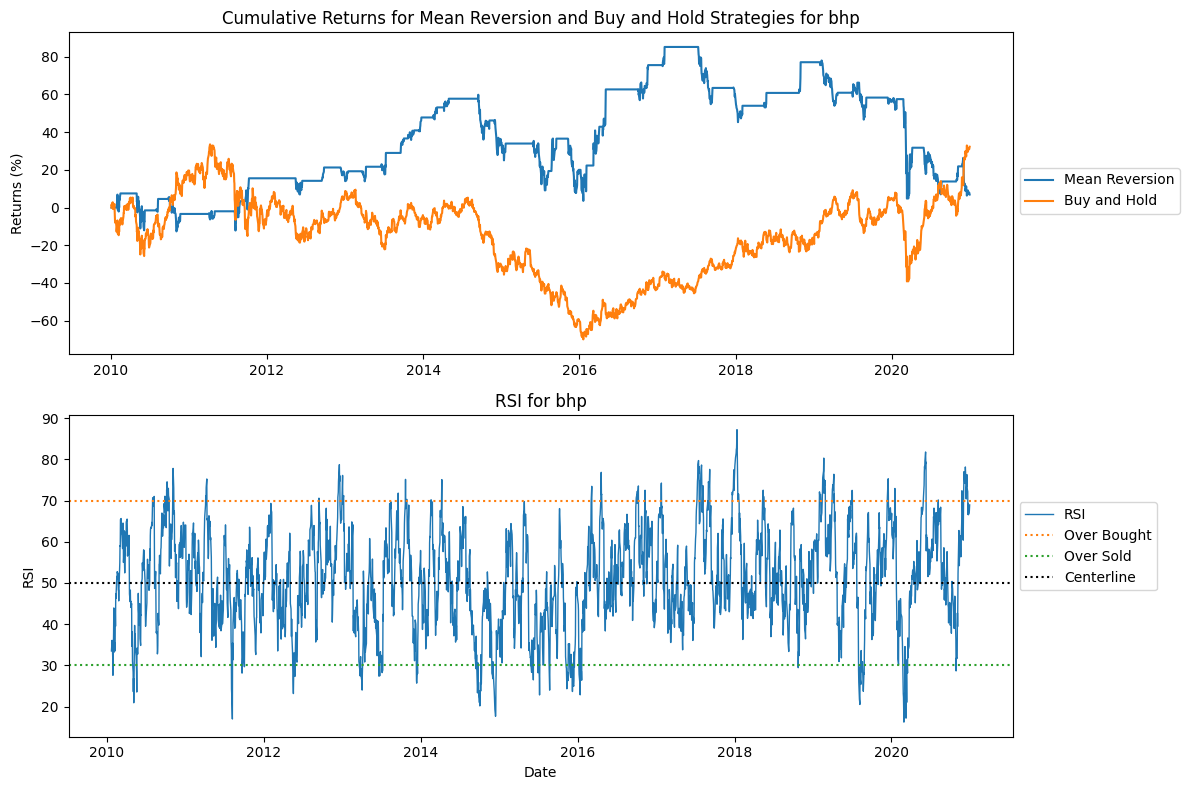

In [72]:
df_rev = RSIReversionStrategy(data.copy())
# Plot results
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(df_rev['strat_cum_returns']*100, label='Mean Reversion')
ax[0].plot(df_rev['cum_returns']*100, label='Buy and Hold')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('Cumulative Returns for Mean Reversion and' +
  f' Buy and Hold Strategies for {ticker}')
ax[0].legend(bbox_to_anchor=[1, 0.6])
ax[1].plot(df_rev['RSI'], label='RSI', linewidth=1)
ax[1].axhline(70, label='Over Bought', color=colors[1], linestyle=':')
ax[1].axhline(30, label='Over Sold', color=colors[2], linestyle=':')
ax[1].axhline(50, label='Centerline', color='k', linestyle=':')
ax[1].set_ylabel('RSI')
ax[1].set_xlabel('Date')
ax[1].set_title(f'RSI for {ticker}')
ax[1].legend(bbox_to_anchor=[1, 0.75])
plt.tight_layout()
plt.show()

Additional helper function

In [73]:
def getStratStats(log_returns: pd.Series, 
  risk_free_rate: float = 0.02):
  stats = {}
  # Total Returns
  stats['tot_returns'] = np.exp(log_returns.sum()) - 1
  # Mean Annual Returns
  stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1
  # Annual Volatility
  stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
  # Sharpe Ratio
  stats['sharpe_ratio'] = (stats['annual_returns'] - 
    risk_free_rate) / stats['annual_volatility']
  # Max Drawdown
  cum_returns = log_returns.cumsum() - 1
  peak = cum_returns.cummax()
  drawdown = peak - cum_returns
  stats['max_drawdown'] = drawdown.max()
  # Max Drawdown Duration
  strat_dd = drawdown[drawdown==0]
  strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
  strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
  strat_dd_days = np.hstack([strat_dd_days,
    (drawdown.index[-1] - strat_dd.index[-1]).days])
  stats['max_drawdown_duration'] = strat_dd_days.max()
  return stats

`getStratStats` is going to return volatility, Sharpe Ratio, and drawdown information so that we can go a tad deeper than just looking at returns.



In [74]:
stats_bh = getStratStats(df_rev['log_returns'])
stats_rev = getStratStats(df_rev['strat_log_returns'])
stats_df = pd.DataFrame()
stats_df = pd.concat([
  pd.DataFrame(stats_bh, index=['Buy and Hold']),
  pd.DataFrame(stats_rev, index=['RSI Mean Reversion'])
])
stats_df

,tot_returns,annual_returns,annual_volatility,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,0.322355,0.025774,0.331881,0.017397,1.490091,3551
RSI Mean Reversion,0.068810,0.006079,0.219405,-0.063449,0.569783,1269


# RSI(2)
The next strategy we’ll look at is known as RSI(2) and was developed by Larry Connors as a short-term mean reversion strategy. It’s very quick, relying on a 2-period RSI and buying/shorting at extreme levels (<10 and >90 respectively). It also has a 200-day simple moving average (SMA) that it looks at as a filter to ensure you’re not buying against a trend.

The strategy works as follows (https://school.stockcharts.com/doku.php?id=trading_strategies%3Arsi2):

Use the price and long-term SMA to find a trend. If the price is above SMA-200, we have an up trend, if the price is below the SMA-200, then we have a down trend.
Use the 2-period RSI to identify buying/shorting opportunities that are congruent with the larger trend. So if the RSI is below 10 and the we’ve identified an upward trend from step 1, then we can buy. We short if the RSI is above 90 and we have a down trend.
Exit a long position if the price moves above a 5-day SMA, or exit a short position if the price is below the 5-day SMA.
There’s a bit more going on here than with the standard RSI, but it provides a good way to think about incorporating additional indicators into our strategy. Notice how Connors uses the RSI in conjunction with the SMA so they’re complementary. We have a trend, so we buy when the RSI shows a deviation from that trend.

Time to get to the code.

In [75]:
# RSI2
def RSI2Strategy(data, P=2, SMA1=200, SMA2=5, long_level=10,
  short_level=90):
  '''
  Short-term RSI strategy based on 2-period RSI to find mean   
  reversions within a larger trend.
  Long when price > SMA1 and RSI > long_level 
    -> exit when price > SMA2
  Short when price < SMA1 and RSI < short_level 
    -> exit when price < SMA2
  '''
  df = calcRSI(data, P=P)
  df['SMA1'] = df['Close'].rolling(SMA1).mean()
  df['SMA2'] = df['Close'].rolling(SMA2).mean()
  position = np.zeros(df.shape[0])
  position[:] = np.nan
  # Enter long positions
  position = np.where(
    (df['RSI']<long_level) & (df['Close']>df['SMA1']), 1, position)
  # Enter short positions
  position = np.where(
    (df['RSI']>short_level) & (df['Close']<df['SMA1']), 
      -1, position)
  # Loop to add exits
  for i, _row in enumerate(df.iterrows()):
    row = _row[1]
    if np.isnan(row['SMA1']):
      position[i] = 0
      continue
    # Exit positions based on SMA2, else hold
    if position[i-1] == 1:
      if row['Close'] > row['SMA2']:
        position[i] = 0
      else:
        position[i] = 1
    elif position[i-1] == -1:
      if row['Close'] < row['SMA2']:
        position[i] = 0
      else:
        position[i] = -1
  df['position'] = position
  df['position'] = df['position'].fillna(0)
  
  return calcReturns(df)

Run and plot the strategy:

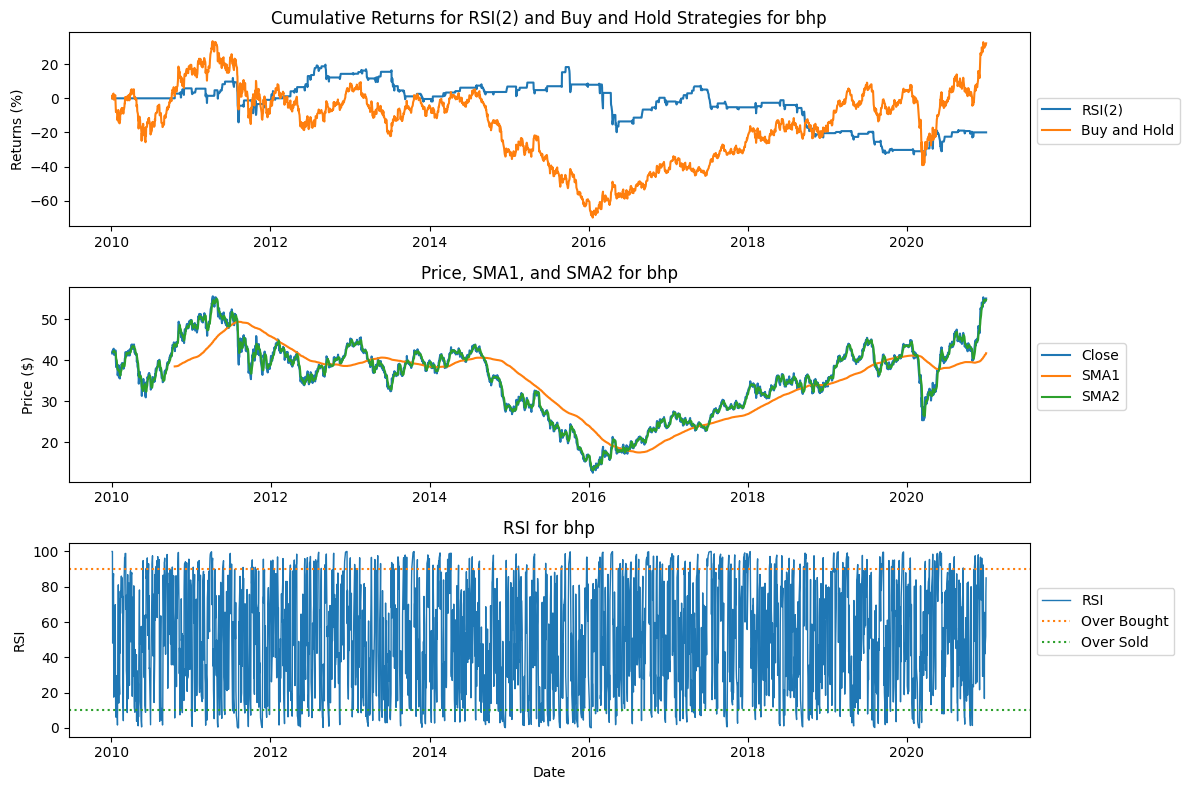

In [76]:
df_rsi2 = RSI2Strategy(data.copy())
# Plot results
fig, ax = plt.subplots(3, figsize=(12, 8))
ax[0].plot(df_rsi2['strat_cum_returns']*100, label='RSI(2)')
ax[0].plot(df_rsi2['cum_returns']*100, label='Buy and Hold')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('Cumulative Returns for RSI(2) and' +
  f' Buy and Hold Strategies for {ticker}')
ax[0].legend(bbox_to_anchor=[1, 0.7])
ax[1].plot(df_rsi2['Close'], label='Close')
ax[1].plot(df_rsi2['SMA1'], label='SMA1')
ax[1].plot(df_rsi2['SMA2'], label='SMA2')
ax[1].set_ylabel('Price ($)')
ax[1].set_title(f'Price, SMA1, and SMA2 for {ticker}')
ax[1].legend(bbox_to_anchor=[1, 0.75])
ax[2].plot(df_rsi2['RSI'], label='RSI', linewidth=1)
ax[2].axhline(90, label='Over Bought', color=colors[1], linestyle=':')
ax[2].axhline(10, label='Over Sold', color=colors[2], linestyle=':')
ax[2].set_ylabel('RSI')
ax[2].set_xlabel('Date')
ax[2].set_title(f'RSI for {ticker}')
ax[2].legend(bbox_to_anchor=[1, 0.8])
plt.tight_layout()
plt.show()

In [77]:
stats_bh = getStratStats(df_rsi2['log_returns'])
stats_rsi2 = getStratStats(df_rsi2['strat_log_returns'])
stats_df = pd.DataFrame()
stats_df = pd.concat([
  pd.DataFrame(stats_bh, index=['Buy and Hold']),
  pd.DataFrame(stats_rsi2, index=['RSI(2)'])
])
stats_df

,tot_returns,annual_returns,annual_volatility,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,0.322355,0.025774,0.331881,0.017397,1.490091,3551
RSI(2),-0.199552,-0.020067,0.148949,-0.269000,0.588990,3033


# RSI as a Momentum Indicator
The RSI can be used to measure the strength of a trend, or its momentum. Going back to our interpretation of the RSI, if it is above the centerline, then we have upward momentum as the recent upward moves are stronger than the recent downward moves. We can take this as a trade indicator to build a strategy around.

For this momentum strategy, we’ll buy when the RSI crosses above the centerline or short in the opposite case. If it reverses and crosses again, then we switch our position, this will act like a quick stop for our model. The goal is to ride it farther by staying in the trade while the RSI rises above 70, and then exiting if it crosses below 70 — although the trend hasn’t quite reversed, we’re trying to get out early when it looks like it has peaked. We do the same on the short side, except now we use 30 as our target level.

Take look at the illustration below to see how the strategy works in these different cases.

In [78]:
# Momentum Strategy
def RSIMomentumStrategy(data, P=14, centerline=50, 
  upper=70, lower=30, shorts=True):
  '''
  Buy when RSI crosses above the centerline, sell if it breaks above 
  the upper threshold then drops below it again or if it goes below 
  the centerline. 
  Short if it drops below the centerline and cover if it breaks 
  below the lower threshold and then above it, or above the 
  centerline.
  '''
  df = calcRSI(data, P=P)
  position = np.zeros(df.shape[0])
  for i, _row in enumerate(df.iterrows()):
    row = _row[1]
    if np.isnan(row['RSI']):
      last_row = row.copy()
      continue
    if row['RSI'] > centerline and last_row['RSI'] < centerline:
      # Buy if no position
      if position[i-1] != 1:
        position[i] = 1
    elif row['RSI'] > centerline and position[i-1] == 1:
      # Check if value has retraced
      if last_row['RSI'] > upper and row['RSI'] < upper:
        position[i] = 0
      else:
        position[i] = 1
    elif position[i-1] == 1 and row['RSI'] < centerline:
      if shorts:
        position[i] = 0
      else:
        position[i] = -1
 
    elif shorts:
      if row['RSI'] < centerline and last_row['RSI'] > centerline:
        # Short if no position
        if position[i-1] != -1:
          position[i] = -1
        elif row['RSI'] < centerline and position[i-1] == -1:
        # Check if value has retraced
          if last_row['RSI'] < lower and row['RSI'] > lower:
            position[i] = 0
          else:
            position[i] = -1
        elif position[i-1] == -1 and row['RSI'] > centerline:
         position[i] = 1
    last_row = row.copy()
  df['position'] = position
  return calcReturns(df)

Testing

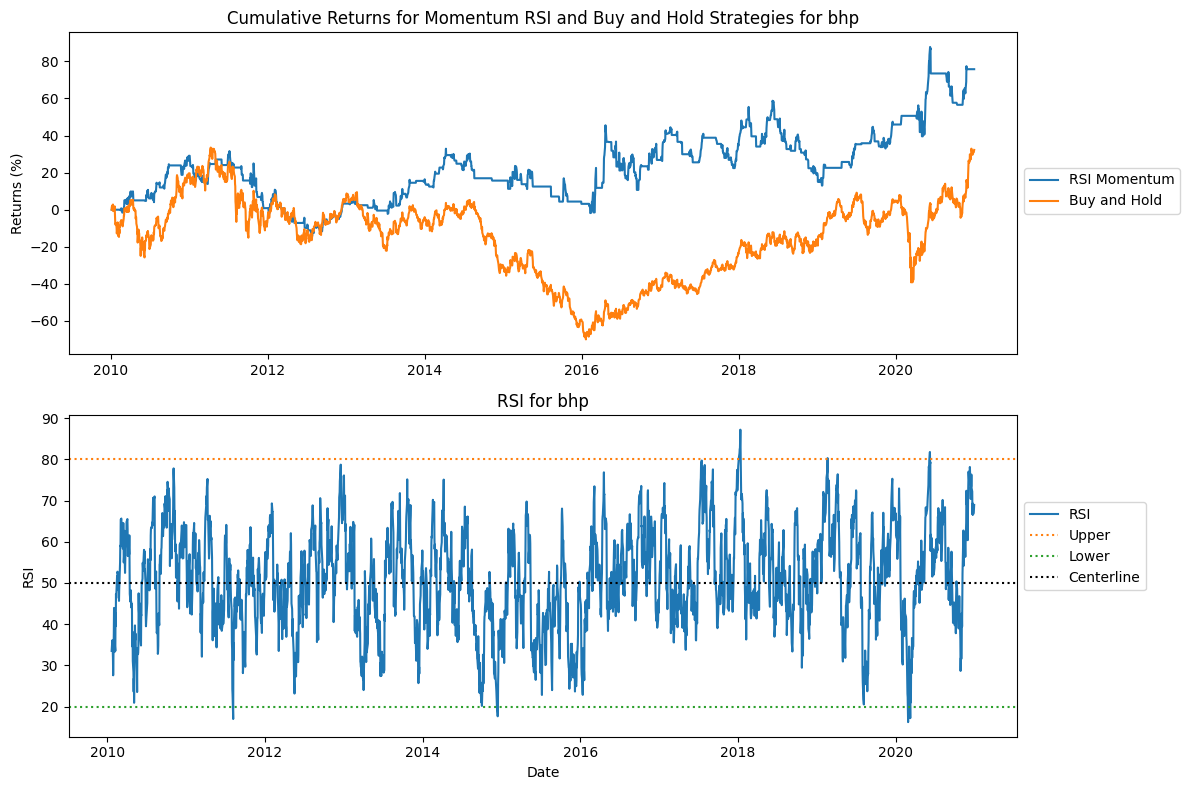

In [79]:
df_mom = RSIMomentumStrategy(data.copy())
# Plot results
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].plot(df_mom['strat_cum_returns']*100, label='RSI Momentum')
ax[0].plot(df_mom['cum_returns']*100, label='Buy and Hold')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('Cumulative Returns for Momentum RSI and' +
  f' Buy and Hold Strategies for {ticker}')
ax[0].legend(bbox_to_anchor=[1, 0.6])
ax[1].plot(df_mom['RSI'], label='RSI')
ax[1].axhline(80, label='Upper', color=colors[1], linestyle=':')
ax[1].axhline(20, label='Lower', color=colors[2], linestyle=':')
ax[1].axhline(50, label='Centerline', color='k', linestyle=':')
ax[1].set_ylabel('RSI')
ax[1].set_xlabel('Date')
ax[1].set_title(f'RSI for {ticker}')
ax[1].legend(bbox_to_anchor=[1, 0.75])
plt.tight_layout()
plt.show()

Get statistics

In [80]:
stats_bh = getStratStats(df_mom['log_returns'])
stats_mom = getStratStats(df_mom['strat_log_returns'])
stats_df = pd.DataFrame()
stats_df = pd.concat([
  pd.DataFrame(stats_bh, index=['Buy and Hold']),
  pd.DataFrame(stats_mom, index=['RSI Momentum'])
])
stats_df

,tot_returns,annual_returns,annual_volatility,sharpe_ratio,max_drawdown,max_drawdown_duration
Buy and Hold,0.322355,0.025774,0.331881,0.017397,1.490091,3551
RSI Momentum,0.757608,0.052703,0.184364,0.177383,0.427870,1007


# RSI and Short-Term Trend
The success of that last strategy got me thinking that we may be able to play on this momentum theme with a short-term trend following system.

This strategy is rather straightforward: buy if RSI is above the centerline and the short-term SMA is above the long-term SMA. Clearly, short and long-term are relative because we are only using 5 and 20-day SMAs for this model. The basic idea is that we’re looking for two signals to agree with one another before entering the trade, and as soon as one of those signals drops, we exit the position; if the momentum is in the same direction as the trend, we buy (or short), otherwise we’re out of the trade.

In [81]:
# Trend Strategy
def RSITrendStrategy(data, P=14, sma1=5, sma2=20, 
  centerline=50, shorts=True):
  '''
  Buy when RSI crosses above centerline and when SMA1>SMA2.
  Sell if one of the conditions are no longer met.
  Short if RSI is below centerline and SMA1<SMA2
  '''
  df = calcRSI(data, P=P)
  df['SMA1'] = df['Close'].rolling(sma1).mean()
  df['SMA2'] = df['Close'].rolling(sma2).mean()
  df['position'] = np.nan
  df['position'] = np.where(
    (df['RSI']>centerline) & (df['SMA1']>df['SMA2']), 1,
    df['position'])
  df['position'] = np.where(
    (df['RSI']<centerline) & (df['SMA1']>df['SMA2']), 0,
    df['position'])
  df['position'] = np.where(
    (df['RSI']>centerline) & (df['SMA1']<df['SMA2']), 0, 
    df['position'])
  
  if shorts:
    df['position'] = np.where(
      (df['RSI']>centerline) & (df['SMA1']>df['SMA2']), -1,
      df['position'])
  else:
    df['position'] = np.where(
      (df['RSI']>centerline) & (df['SMA1']>df['SMA2']), 0,   
      df['position'])
  df['position'] = df['position'].ffill().fillna(0)
  return calcReturns(df)

Give it a try

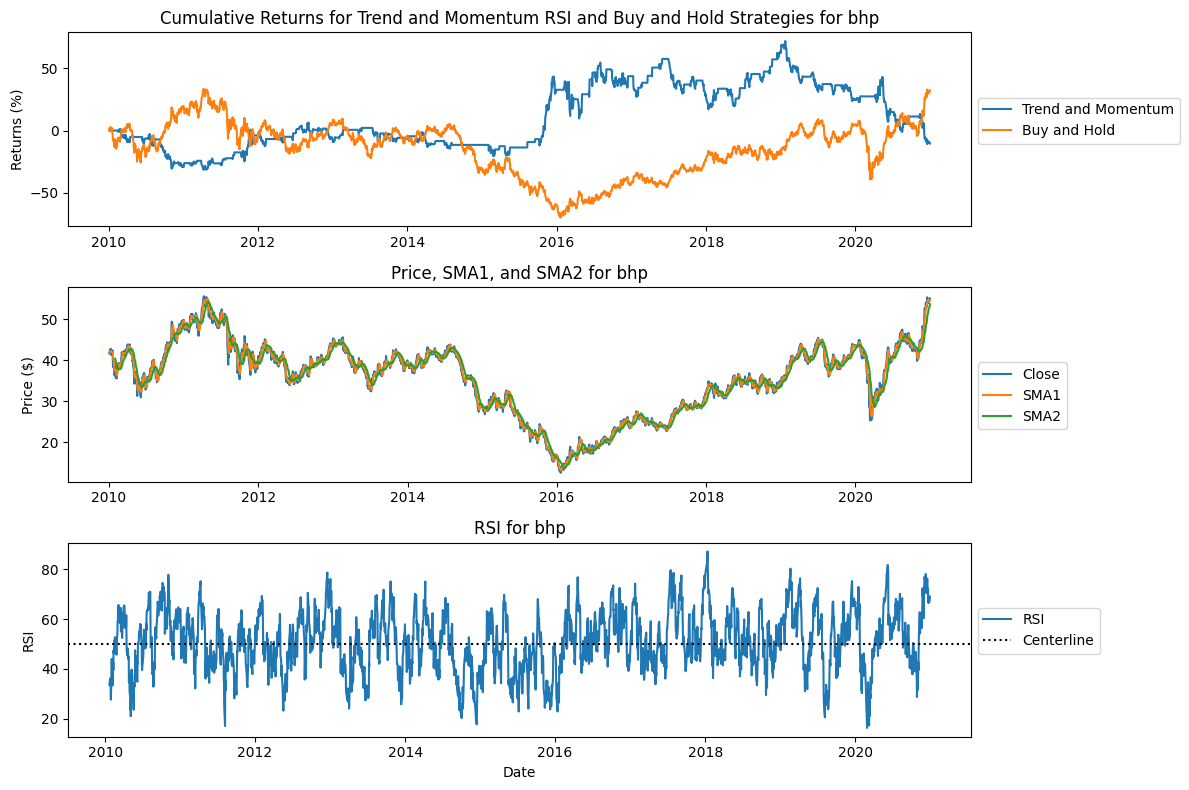

In [82]:
df_trend = RSITrendStrategy(data.copy())
# Plot results
fig, ax = plt.subplots(3, figsize=(12, 8))
ax[0].plot(df_trend['strat_cum_returns']*100, 
  label='Trend and Momentum')
ax[0].plot(df_trend['cum_returns']*100, label='Buy and Hold')
ax[0].set_ylabel('Returns (%)')
ax[0].set_title('Cumulative Returns for Trend and Momentum RSI and'+
 f' Buy and Hold Strategies for {ticker}')
ax[0].legend(bbox_to_anchor=[1, 0.7])
ax[1].plot(df_trend['Close'], label='Close')
ax[1].plot(df_trend['SMA1'], label='SMA1')
ax[1].plot(df_trend['SMA2'], label='SMA2')
ax[1].set_ylabel('Price ($)')
ax[1].set_title(f'Price, SMA1, and SMA2 for {ticker}')
ax[1].legend(bbox_to_anchor=[1, 0.65])
ax[2].plot(df_trend['RSI'], label='RSI')
ax[2].axhline(50, label='Centerline', color='k', linestyle=':')
ax[2].set_ylabel('RSI')
ax[2].set_xlabel('Date')
ax[2].set_title(f'RSI for {ticker}')
ax[2].legend(bbox_to_anchor=[1, 0.7])
plt.tight_layout()
plt.show()